### Importing the necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
import os
import cv2
# imghdr was removed/changed in newer Python; a fallback using Pillow is provided in the data-processing cell

### Data Pipeline

In [11]:
# Define the path to the extracted dataset
data_dir = r'C:\Users\Hp\Documents\MCE411 Assignment\paddy-doctor-diseases-small-augmented-26k'  # Update this to your current dataset directory

# Path to metadata (if it's a CSV file, adjust accordingly)
metadata_path = os.path.join(data_dir, 'metadata.csv')

# Load metadata
metadata = pd.read_csv(metadata_path)
print("First few rows of metadata:")
print(metadata.head())  # To inspect metadata

# Image extensions to keep
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Helper function: determine image type robustly
try:
    from PIL import Image
    PIL_AVAILABLE = True
except Exception:
    PIL_AVAILABLE = False


def detect_image_type(path):
    """Return a lowercase extension (without dot) if detected, otherwise None."""
    # Fast path: use file extension
    ext = os.path.splitext(path)[1].lower().lstrip('.')
    if ext in image_exts:
        return ext

    # Next: try Pillow if available
    if PIL_AVAILABLE:
        try:
            with Image.open(path) as im:
                fmt = im.format.lower()
                return fmt
        except Exception:
            return None

    # Last resort: use OpenCV to attempt reading if available
    if CV2_AVAILABLE:
        try:
            img = cv2.imread(path)
            if img is None:
                return None
            # No reliable format returned by cv2; fall back to extension-less detection
            return os.path.splitext(path)[1].lower().lstrip('.')
        except Exception:
            return None

    return None

# Process each image class (folder)
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)

    # Skip if it's not a directory (e.g., metadata.csv file)
    if not os.path.isdir(class_path):
        print(f"Skipping non-folder item: {image_class}")
        continue

    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)

        # Process image if it's a valid file
        try:
            img_type = detect_image_type(image_path)
            if img_type not in image_exts:
                print(f'Image not in ext list or not detected: {image_path} (detected: {img_type})')
                # Optionally remove invalid files; commented out by default
                # os.remove(image_path)
            else:
                # Read image using OpenCV if available, otherwise Pillow
                img = None
                if CV2_AVAILABLE:
                    img = cv2.imread(image_path)
                elif PIL_AVAILABLE:
                    try:
                        with Image.open(image_path) as im:
                            img = np.array(im.convert('RGB'))
                    except Exception:
                        img = None

                if img is None:
                    print(f'Failed to load image: {image_path}')
                # else:
                #     print(f'Loaded {image_path} from {image_class}')
        except Exception as e:
            print(f'Issue with image {image_path}: {e}')


First few rows of metadata:
           image_id                  label variety  age
0  PDD00001_001.jpg  bacterial_leaf_blight      45   65
1  PDD00001_002.jpg  bacterial_leaf_blight      45   65
2  PDD00001_003.jpg  bacterial_leaf_blight      45   65
3  PDD00002_001.jpg  bacterial_leaf_blight      45   60
4  PDD00002_002.jpg  bacterial_leaf_blight      45   60
Skipping non-folder item: metadata.csv
Skipping non-folder item: metadata.csv


In [12]:
dataset = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Hp\Documents\MCE411 Assignment\paddy-doctor-diseases-small-augmented-26k')

Found 26000 files belonging to 13 classes.


In [13]:
data_iterator = dataset.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

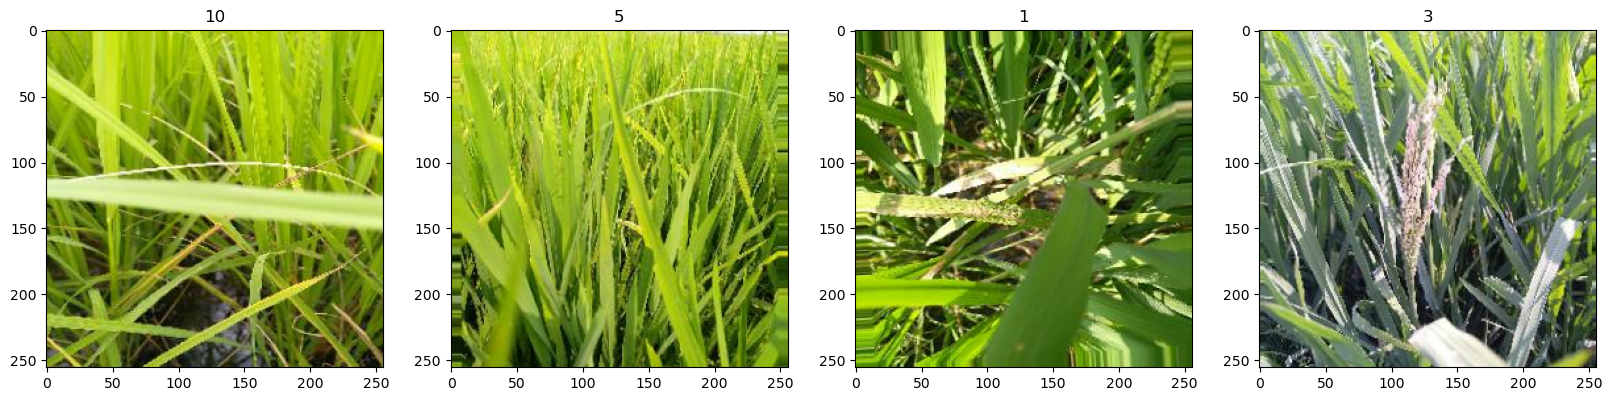

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [19]:
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

In [20]:
dataset.as_numpy_iterator().next()

(array([[[[0.41568628, 0.5529412 , 0.05882353],
          [0.41960785, 0.5568628 , 0.0627451 ],
          [0.41960785, 0.5568628 , 0.05490196],
          ...,
          [0.12941177, 0.29803923, 0.        ],
          [0.14509805, 0.31764707, 0.00784314],
          [0.10196079, 0.27450982, 0.        ]],
 
         [[0.36862746, 0.5058824 , 0.01176471],
          [0.36862746, 0.5058824 , 0.01176471],
          [0.36862746, 0.5058824 , 0.01176471],
          ...,
          [0.12941177, 0.29803923, 0.        ],
          [0.16470589, 0.3372549 , 0.04313726],
          [0.15686275, 0.32941177, 0.03529412]],
 
         [[0.31764707, 0.45882353, 0.        ],
          [0.31764707, 0.45882353, 0.        ],
          [0.31764707, 0.45882353, 0.        ],
          ...,
          [0.11372549, 0.27450982, 0.        ],
          [0.12941177, 0.29411766, 0.03529412],
          [0.14509805, 0.30980393, 0.05882353]],
 
         ...,
 
         [[0.14901961, 0.34901962, 0.03921569],
          [0.14901

### Data Splitting

In [22]:
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2)
test_size = int(len(dataset)*.1)

In [23]:
train_size

569

In [29]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [30]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

### Model Training

In [39]:
model = Sequential([
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(13, activation='softmax')
])  

c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile('adam', 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=['accuracy'])

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train,
    validation_data=val,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5326 - loss: 1.4500

569/569 ━━━━━━━━━━━━━━━━━━━━ 159s 280ms/step - accuracy: 0.5579 - loss: 1.3603 - val_accuracy: 0.6262 - val_loss: 1.1642 - learning_rate: 0.0010
Epoch 2/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 152s 267ms/step - accuracy: 0.6901 - loss: 0.9384 - val_accuracy: 0.5361 - val_loss: 1.9210 - learning_rate: 0.0010
Epoch 3/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 156s 274ms/step - accuracy: 0.7839 - loss: 0.6589 - val_accuracy: 0.6375 - val_loss: 1.3446 - learning_rate: 0.0010
Epoch 4/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8228 - loss: 0.5226

569/569 ━━━━━━━━━━━━━━━━━━━━ 158s 278ms/step - accuracy: 0.8312 - loss: 0.5046 - val_accuracy: 0.6954 - val_loss: 1.0830 - learning_rate: 0.0010
Epoch 5/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 158s 277ms/step - accuracy: 0.8557 - loss: 0.4328 - val_accuracy: 0.5839 - val_loss: 1.8488 - learning_rate: 0.0010
Epoch 6/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 154s 271ms/step - accuracy: 0.8746 - loss: 0.3741 - val_accuracy: 0.6964 - val_loss: 1.1815 - learning_rate: 0.0010
Epoch 7/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 159s 279ms/step - accuracy: 0.8926 - loss: 0.3288 - val_accuracy: 0.5687 - val_loss: 2.2441 - learning_rate: 0.0010
Epoch 8/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9164 - loss: 0.2391

569/569 ━━━━━━━━━━━━━━━━━━━━ 155s 272ms/step - accuracy: 0.9270 - loss: 0.2106 - val_accuracy: 0.7564 - val_loss: 0.9645 - learning_rate: 5.0000e-04
Epoch 9/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9435 - loss: 0.1684

569/569 ━━━━━━━━━━━━━━━━━━━━ 159s 279ms/step - accuracy: 0.9441 - loss: 0.1656 - val_accuracy: 0.7753 - val_loss: 0.8779 - learning_rate: 5.0000e-04
Epoch 10/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 153s 269ms/step - accuracy: 0.9471 - loss: 0.1560 - val_accuracy: 0.7676 - val_loss: 0.9824 - learning_rate: 5.0000e-04
Epoch 11/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 155s 272ms/step - accuracy: 0.9545 - loss: 0.1363 - val_accuracy: 0.7076 - val_loss: 1.2698 - learning_rate: 5.0000e-04
Epoch 12/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 156s 273ms/step - accuracy: 0.9588 - loss: 0.1233 - val_accuracy: 0.7024 - val_loss: 1.4203 - learning_rate: 5.0000e-04
Epoch 13/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 156s 274ms/step - accuracy: 0.9673 - loss: 0.0939 - val_accuracy: 0.7776 - val_loss: 0.9375 - learning_rate: 2.5000e-04
Epoch 14/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 155s 272ms/step - accuracy: 0.9733 - loss: 0.0829 - val_accuracy: 0.7892 - val_loss: 0.9017 - learning_rate: 2.5000e-04
Epoch 15/30
569/569 ━━━━━━━━━━━━━━━━━━━━ 175s 

### Model Evaluation

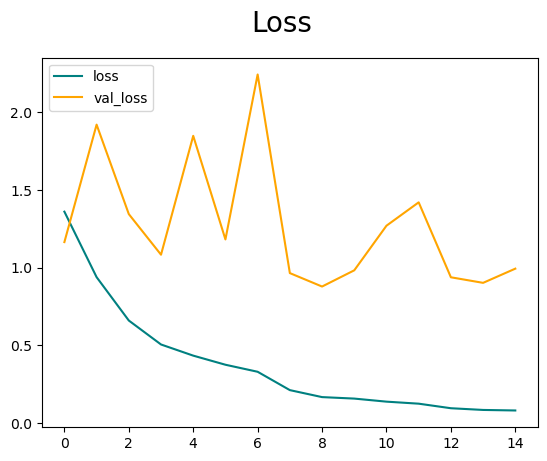

In [44]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

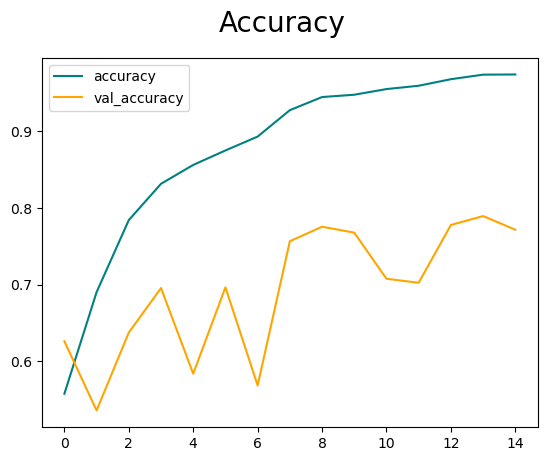

In [45]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [47]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [49]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat_probs = model.predict(X)                 # shape (batch, 13)
    yhat = np.argmax(yhat_probs, axis=1)          # shape (batch,) (class indices)
    yhat = yhat.astype(y.dtype)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

In [50]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.97657883, shape=(), dtype=float32) tf.Tensor(0.9806804, shape=(), dtype=float32) tf.Tensor(0.050925925, shape=(), dtype=float32)


In [51]:
y_trues = []
y_preds = []
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = np.argmax(model.predict(X), axis=1)
    y_trues.append(y)
    y_preds.append(yhat)

y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

### Test

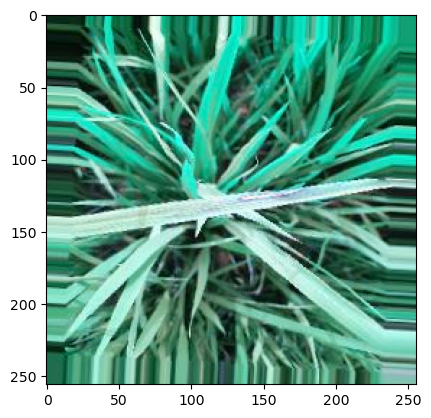

In [54]:
img = cv2.imread(r'C:\Users\Hp\Documents\MCE411 Assignment\paddy-doctor-diseases-small-augmented-26k\bacterial_leaf_blight\PDD00647_003.jpg')
plt.imshow(img)
plt.show()

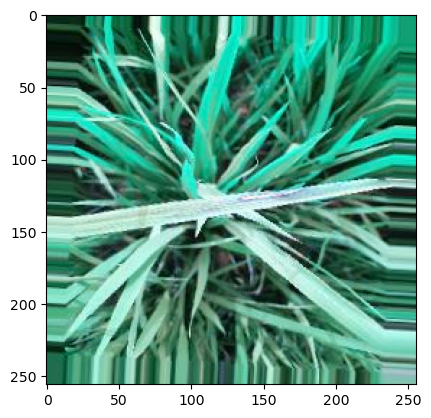

In [55]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [58]:
class_names = []
for image_class in os.listdir(data_dir):
    class_names.append(image_class)
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'black_stem_borer', 'blast', 'brown_spot', 'downy_mildew', 'hispa', 'leaf_roller', 'metadata.csv', 'normal', 'tungro', 'white_stem_borer', 'yellow_stem_borer']


In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

predicted_indices = np.argmax(y_hat, axis=1)
predicted_class_names = [class_names[idx] for idx in predicted_indices]

print(f"Probabilities: {y_hat}")
print(f"Predicted class index: {predicted_class_index}")